In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rcParams['figure.figsize'] = (30, 30)

import re
import spacy
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
import networkx as nx

from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm

from sklearn.decomposition import PCA
import community

In [ ]:
df = pd.read_json('../data/calm_records.json')

df['AltRefNo'] = df['AltRefNo'].dropna().apply(lambda x: x[0])
df['Level'] = df['Level'].dropna().apply(lambda x: x[0])

In [3]:
collection_ids = [id for id in sorted(df['AltRefNo'][df['Level'] == 'Collection'].values)]

In [4]:
df = df.set_index('AltRefNo')

In [5]:
collection_descriptions = (df['AdminHistory']
                           [collection_ids]
                           .dropna()
                           .apply(lambda x: x[0]))
collection_descriptions

AltRefNo
3473                   The Holloway Sanatorium, St. Anne's Heath, Vir...
8855                   The Holloway Sanatorium, St. Anne's Heath, Vir...
AAU/FAS                MEFASH has its origins in a charity founded in...
AML                    <p>Lieutenant Colonel Arthur Martin Leake VC &...
ART/AFH                In 1988 Arts for Health (AfH) was founded as a...
ART/COO                <p>Graham Cooper is an art practitioner workin...
ART/GEO                Alexandra Georgiou was a Greek-Cypriot, who tr...
ART/IOW                Healing Arts is the arts in health department ...
ART/LAB                <p>Langley Brown is an artist, writer and rese...
ART/MIW                Mike worked closely with Arts for Health, on v...
ART/SAH                <p>Stockport Arts & Health (SA&H) was establis...
ART/WIT                The Arts and Health Witness Seminar and the Mi...
DGH1                   <p>Crichton Royal Institution was Scotland's s...
GALTON                 <p>\nFrancis Galton

In [6]:
ent_types = ['PERSON', 
             'NORP', 
             'FACILITY', 
             'ORG', 
             'GPE', 
             'LOC', 
             'PRODUCT', 
             'EVENT', 
             'WORK_OF_ART', 
             'LAW', 
             'LANGUAGE']

In [7]:
nlp = spacy.load('en')

In [8]:
entities_in_descriptions = pd.Series()
for id, record in tqdm(list(collection_descriptions.items())):
    plain_text = BeautifulSoup(record, 'html.parser').get_text()
    doc = nlp(plain_text)
    entities_in_descriptions[id] = [str(ent) for ent in doc.ents]

HBox(children=(IntProgress(value=0, max=874), HTML(value='')))

In [9]:
def flatten(list_of_lists):
    return [j for i in list_of_lists for j in i]

In [10]:
unique_entities = np.unique(flatten(entities_in_descriptions))

In [11]:
occurences = pd.DataFrame(data=[[entities_in_descriptions[collection].count(entity) 
                                 for entity in unique_entities]
                                for collection in tqdm(collection_descriptions.index.values)],
                          index=collection_descriptions.index.values,
                          columns=unique_entities)

HBox(children=(IntProgress(value=0, max=874), HTML(value='')))

In [15]:
adjacency = pd.DataFrame(data=occurences.values.T.dot(occurences.values),
                         index=unique_entities,
                         columns=unique_entities)

In [16]:
adjacency.shape

(15486, 15486)

In [17]:
G = nx.from_pandas_adjacency(adjacency)

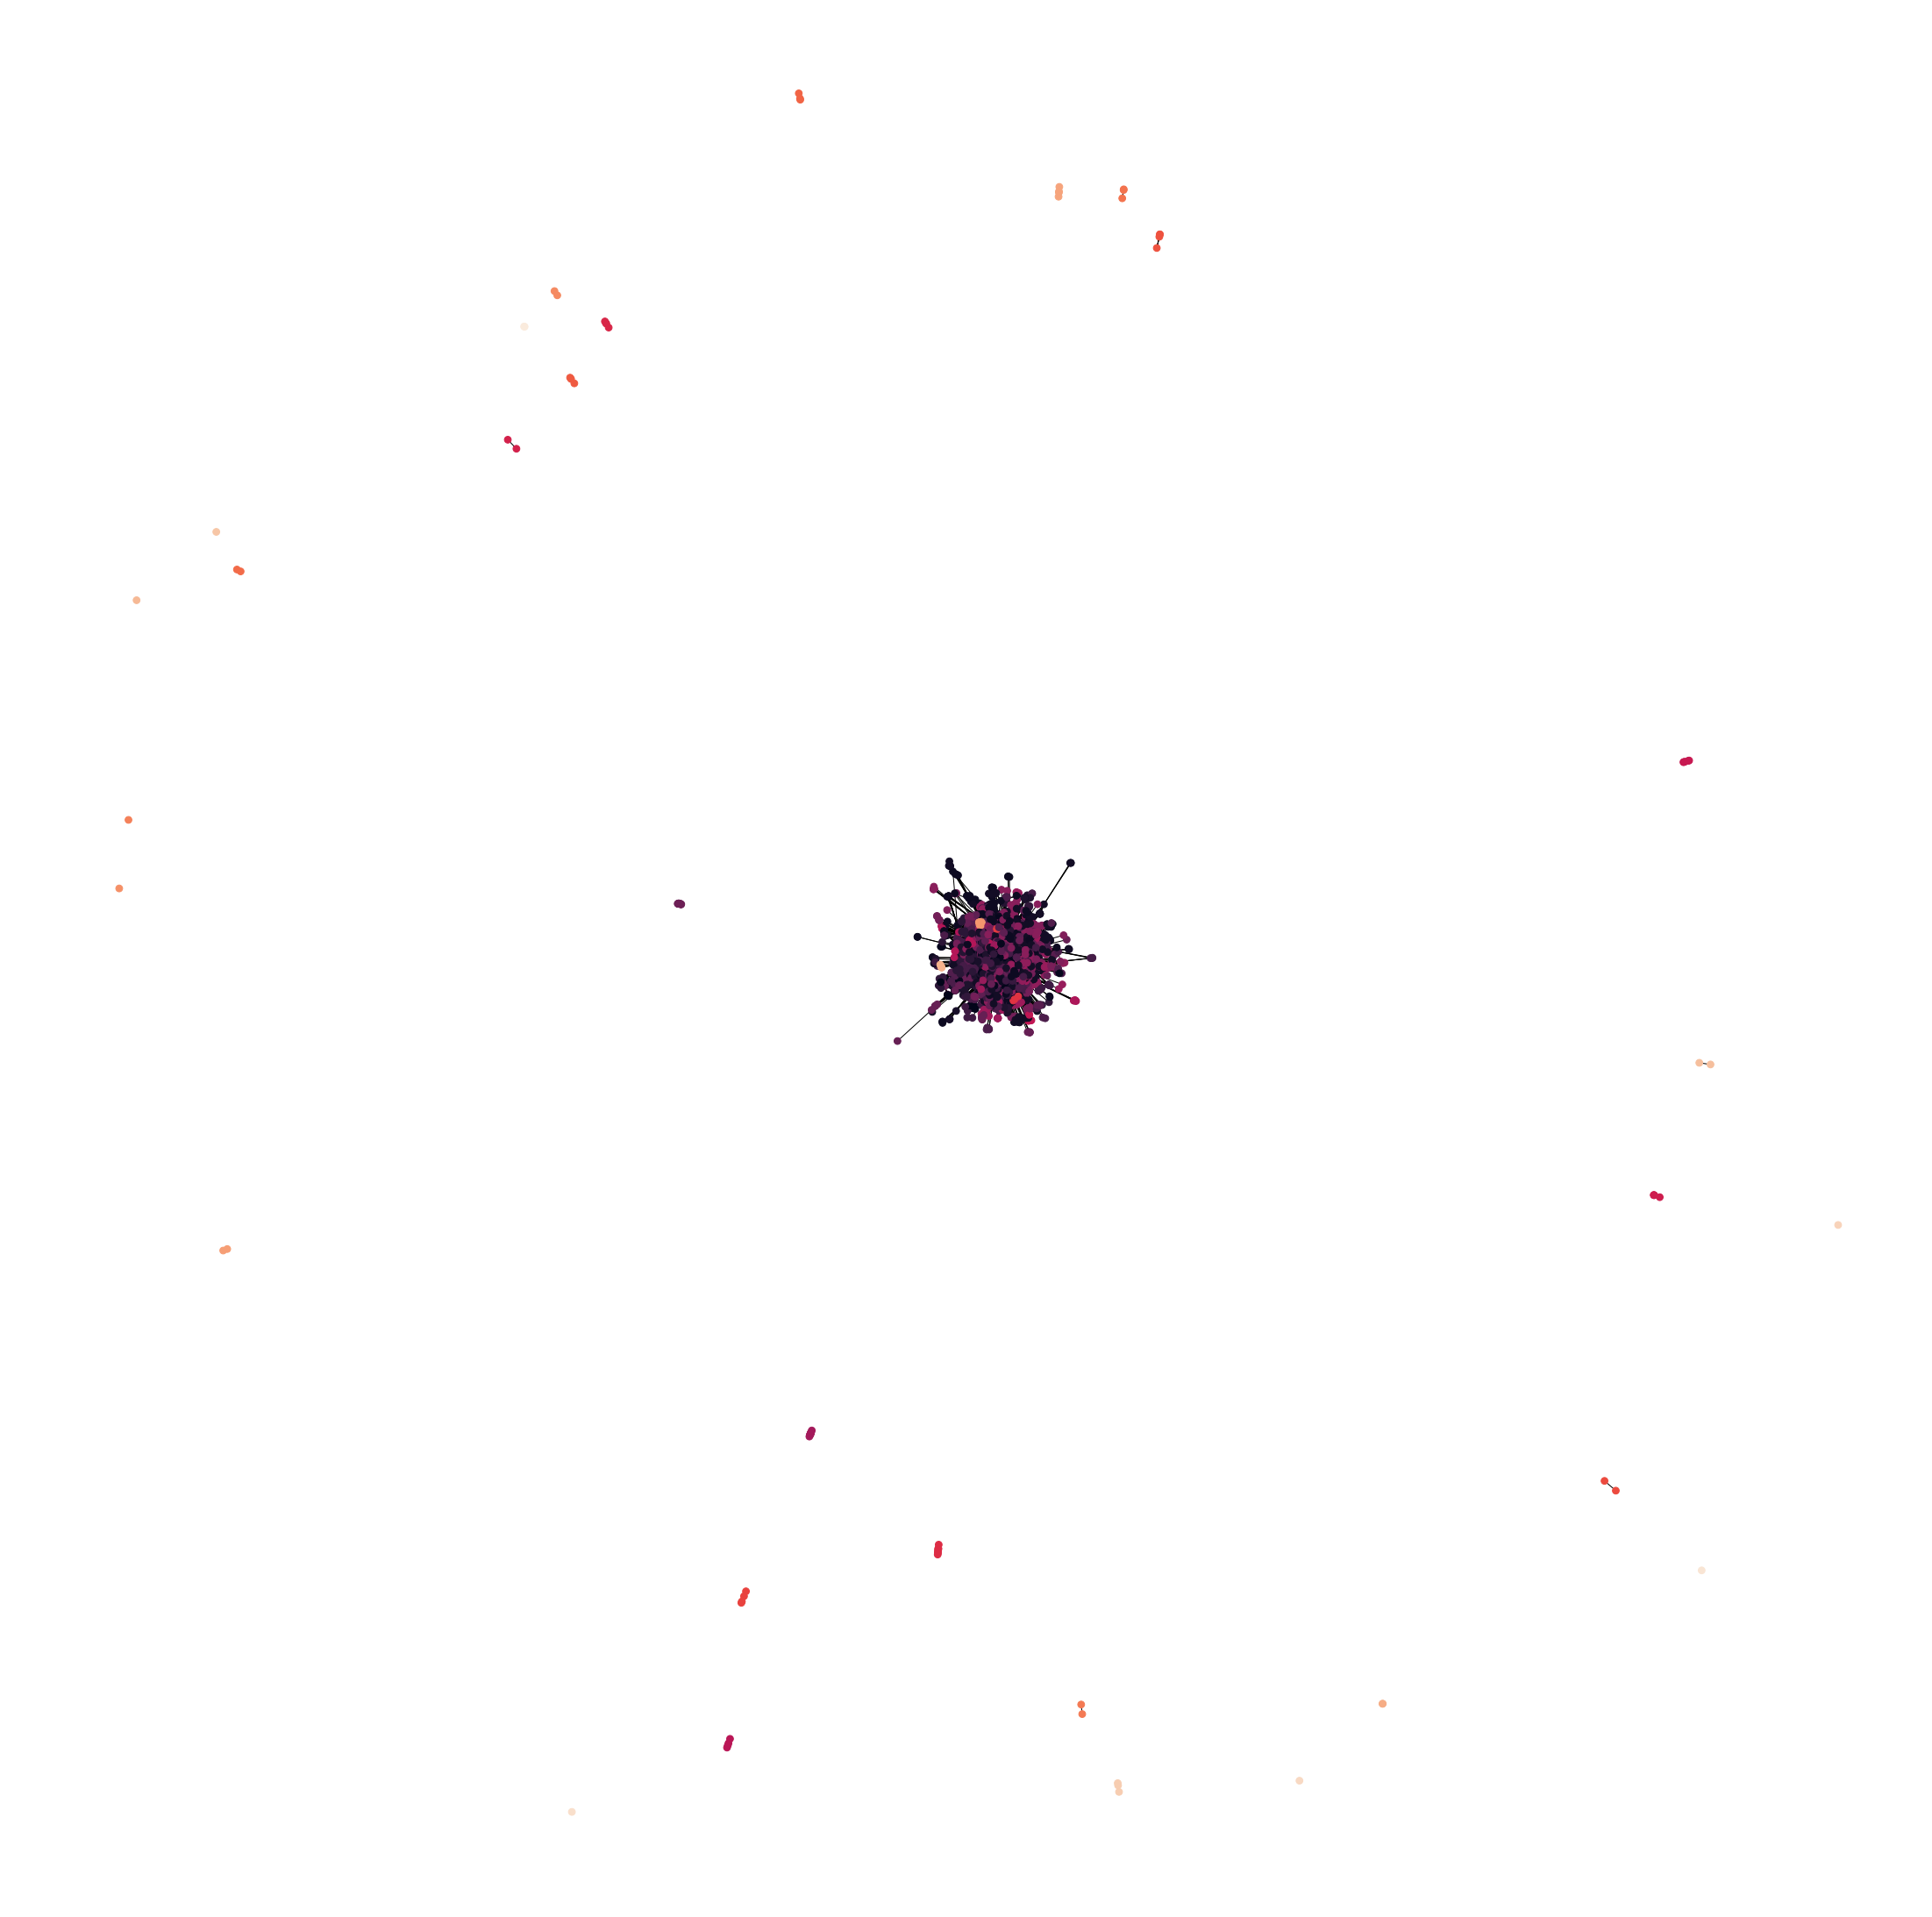

In [20]:
partitions = community.best_partition(G)
values = [partitions.get(node) for node in G.nodes()]

nx.draw_spring(G, 
               node_size=60, 
               node_color=values)

In [ ]:
embedding_nd = pd.DataFrame(PCA(n_components=50)
                              .fit_transform(adjacency))

In [ ]:
embedding_2d = pd.DataFrame(UMAP(n_components=2).fit_transform(embedding_nd.values))

embedding_2d.plot.scatter(x=0, y=1);

In [ ]:
n_clusters = 8
embedding_2d['labels'] = KMeans(n_clusters).fit_predict(embedding_2d.values)
embedding_2d.plot.scatter(x=0, y=1, c='labels', cmap='Paired');

In [ ]:
cluster = 7
collection_ids_in_cluster = (collection_descriptions.index.values
                             [embedding_2d[embedding_2d['labels'] == cluster]
                              .index.values])
collection_ids_in_cluster

In [ ]:
pd.Series(flatten(entities_in_descriptions[collection_ids_in_cluster].tolist())).value_counts()